# IMPORTS

In [ ]:
pip install spectral

In [ ]:
pip install -U albumentations

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import cv2
import imghdr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
# from google.colab import drive
import sys
import PIL
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications
#from keras.preprocessing.image import load_img
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import RandomNormal, Constant
from keras.callbacks import ModelCheckpoint


# Savvas Function for HS Images

In [ ]:
import re
import pickle
from glob import glob
from copy import copy , deepcopy
from scipy.ndimage import  median_filter

def demosaic(image,mosaic_shape:(int) =None,cam_type:(str)= None ,upsample:(bool)=False,wv_ordered:(bool)=False):
    """Convert raw binary images to np.array.
    Parameters
    ----------
    image: 2D np.array
        2D interleaved-uncoupled- image.
    mosaic_shape: int
        The size of the SSM mosaic.
    upsample: bool
        Apply Bicubic interpolation to 3D Hypercube to match the dimensions of the original image.
    wv_ordered: bool
        If True returns channels aranged in wavelength ascending order, otherwise channels are aranged in sensor index asceding order.
    Returns
    ----------
    final: 3D Hypercube as np.array.
    """
    types = {'vis', 'nir'}
    assert mosaic_shape or cam_type, 'You must either specify mosaic shape (int) or camera type (NIR/VIS)'
    if cam_type:
        cam_type = cam_type.lower()
        assert cam_type in types,f'Acceptable camera types are {types}'
        mosaic_shape  = 4 if cam_type == 'vis' else 5
    assert mosaic_shape == 4 or mosaic_shape == 5, 'The Supported Mosaic Shapes are 4x4 and 5x5'

    # Normalize input image
    img = image.astype(np.float32)/4095 if image.dtype != np.float32 else image

    #Start Reconstruction
    for band in range(mosaic_shape**2):
        offset_i = band//mosaic_shape
        offset_j = band%mosaic_shape
        tmp = img[offset_i::mosaic_shape,offset_j::mosaic_shape]
        if offset_j==0 and mosaic_shape==5 :
            tmp = tmp[:,:-1]
        final = copy(tmp) if band == 0 else np.dstack((final,tmp))

    # Interpolation if needed
    if upsample :
        final = cv2.resize(final,dsize=(img.shape[1],img.shape[0]),interpolation = cv2.INTER_LINEAR)

    # Return Hypercube
    tup = (2,3,0,1,15,14,12,13,7,6,4,5,11,10,9,8) if mosaic_shape==4 else (5,14,13,12,10,11,9,8,6,7,23,22,20,21,3,2,0,1,18,17,15,16,24,19,4)
    if wv_ordered:
        return final[:,:,tup]
    else:
        return final

def fix_pixels(image,factor:(float)=3.5,visualize:(bool)=False):
    """Identifies corrupted pixels in a hyperspectral image of np.ndarray format based on input's std.
    Parameters
    ----------
    image: np.ndarray
        N-dimensional array in rasterio band order (bands, rows, columns).
    factor: float
        Multiplicative factor to define the threshold (threshold = factor*np.std(diff)).
    visualize: bool
        If true shows the location of the corrupted pixels found in input image.
    Returns
    ----------
    fixed_image: np.ndarray
        Image with the corrupted pixels removed.
    """
    filter_image = median_filter(image,2)
    diff = np.subtract(image,filter_image,dtype=np.float32)
    threshold = factor*np.std(diff)

    #locate hot pixels
    spikes_loc =np.nonzero(np.abs(diff>threshold))
    spikes_loc = np.array(spikes_loc)

    #Fix them
    fixed_image = np.copy(image)
    for x,y in zip(spikes_loc[0],spikes_loc[1]):
        fixed_image[x,y] = filter_image[x,y]

    #visualize
    if visualize :
        plt.imshow(image)
        plt.show()
        plt.imshow(image)
        for y,x in zip(spikes_loc[0],spikes_loc[1]):
            plt.plot(x,y,'ro',mfc='none',mec='r',ms=10)
        plt.show()

    return fixed_image

def raw2np(path:(str),fix_hot:(bool)=False,dms:(bool)=False,upsample:(bool)=False,wv_ordered:(bool)=False):
    """Convert raw binary images to np.array.
    Parameters
    ----------
    path: str
        Path to binary (.raw) image.
    fix_hot: bool
        Fix hot pixels in 2D image.
    dms: bool
        Convert 2D array to 3D Hypercube.
    upsample: bool
        Apply Bicubic interpolation to 3D Hypercube to match the dimensions of the original image.
     wv_ordered: bool
        If True returns channels aranged in wavelength ascending order, otherwise channels are aranged in sensor index asceding order.
    Returns
    ----------
    img: 2D np.array - if dms==False - or 3D np.array - if dms == True - .
    """

    # Use RegEx to match string cam*
    cam = re.compile(r'cam\d')
    # Read raw binary image as 1D np.array
    npimg = np.fromfile(path, dtype=np.uint16,  sep='')
    # Reashape 1D -> 2D based on camera type
    #if cam.search(path).group() =='cam1':
    img = npimg.reshape(1080,2016)
    #else:
    #  img= npimg.reshape(1024,1536)

    #Convert 2D np.array to 3D Hypercube, if wanted
    if fix_hot:
        img = fix_pixels(img,factor=5)
    if dms :
        mosaic_shape = 4 if cam.search(path).group() =='cam1' else 5
        img = demosaic(image=img,mosaic_shape=mosaic_shape,upsample=upsample,wv_ordered=wv_ordered)
    #Return image
    return img

def parse(path,save:(bool)=True,dms:(bool)=False,fix_pixels:(bool)=True,visualize:(bool)=True,wv_ordered:(bool)=False):
    """
    Parameters
    ----------
    path : str
        Path to hyperspectral raw images.
    save : bool
        Return VIS and NIR images in two list respectively.
    dms : bool
        Apply demoisaicing in hyperspectral image to get 3D hypercube
    fix_pixels : bool
        Fix corrupted pixels in original image.
    visualize : bool
        Show images stored in path.
    wv_ordered: bool
        If True returns channels aranged in wavelength ascending order, otherwise channels are aranged in sensor index asceding order.
    Returns
    ----------
    (VIS,NIR) : tuple
        If save==True returns two list of VIS and NIR images in np.ndarray format.
    """
    VIS = [] if save else None
    NIR = [] if save else None
    for i,(im1, im2) in enumerate(zip(sorted(glob(path+'/cam1/*')),sorted(glob(path+'/cam2/*')))):
        if save :
            VIS.append(raw2np(im1,fix_hot=fix_pixels,dms=dms,wv_ordered=wv_ordered))
            NIR.append(raw2np(im2,fix_hot=fix_pixels,dms=dms,wv_ordered=wv_ordered))
        if visualize :
            f,ax=plt.subplots(1,2,figsize=(10,10))
            ax[0].imshow(raw2np(im1))
            ax[0].set_title(f'Image{i}')
            ax[1].imshow(raw2np(im2))
            f.show()
    if save:
        return VIS ,NIR


# use savvas function to put to arrays Vis2 and Nir2 the HS 3d Hypercubes

In [ ]:
path1='drive/MyDrive/pathiasmeno'
Vis2, Nir2 = parse(path=path1,save=True,dms=True,visualize=False,)

# keeping first 3 PCA from HS images and saving them

In [ ]:
from spectral import principal_components,imshow,envi,save_rgb

for i in range (len(Vis2)):
  Vis3=np.array(Vis2[i])
  pc= principal_components(Vis3)
  pc3=pc.reduce(num=3)
  img_pc = pc3.transform(Vis3)

  Nir3=np.array(Nir2[i])
  pc2= principal_components(Nir3)
  pc32=pc2.reduce(num=3)
  image_25 = pc32.transform(Nir3)

  if i+1<10:
    save_rgb('PET_vis/PET_vis_00'+str(i+1)+'.png',img_pc)
    save_rgb('PET_nir/PET_nir_00'+str(i+1)+'.png',image_25)
  elif i+1<100:
    save_rgb('PET_vis/PET_vis_0'+str(i+1)+'.png',img_pc)
    save_rgb('PET_nir/PET_nir_0'+str(i+1)+'.png',image_25)
  else:
    save_rgb('PET_vis/PET_vis_'+str(i+1)+'.png',img_pc)
    save_rgb('PET_nir/PET_nir_'+str(i+1)+'.png',image_25)

# Move Files

In [ ]:
import os
from tempfile import TemporaryFile
from pathlib import Path
import shutil

dirName='drive/MyDrive/AllDatasetRGB/AllDatasetRGB_train/PP'
files = os.listdir(dirName)
counter=0
for file_name in thefilenames:
  if(file_name=='.ipynb_checkpoints'):
    continue
  counter+=1
  shutil.move(dirName+'/'+file_name,'drive/MyDrive/AllDatasetRGB/AllDatasetRGB_val/PP')
  if (counter>=52*6):
    break


# TensorFlow MY simple MODEL saving best state

In [ ]:
batch_size = 32
img_height = 270 # 8elei 1024 x 1280 or sth
img_width = 504
data_dir='/home/savvas/Desktop/AllDataset/AllDatasetNIR/AllDatasetNIR_train'
data_dir2= '/home/savvas/Desktop/AllDataset/AllDatasetNIR/AllDatasetNIR_val'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
#normalization_layer = layers.Rescaling(1./255)
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
epochs=20

filepath = '/home/savvas/Desktop/AllDataset/modelsAll/my_best_modelNIR_Simple.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=callbacks)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

resnet_model.save(os.path.join('/home/savvas/Desktop/AllDataset/modelsAll','imageclassifierNIR_SimpleModel.h5'))

# Tensorflow ResNet 50 VIS saving best state

In [ ]:
batch_size = 32
img_height = 270 # 8elei 1024 x 1280 or sth
img_width = 504
data_dir='/home/savvas/Desktop/AllDataset/AllDatasetVIS/AllDatasetVIS_train'
data_dir2= '/home/savvas/Desktop/AllDataset/AllDatasetVIS/AllDatasetVIS_val'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
epochs=20


tf.keras.backend.clear_session()
strategy = tf.distribute.MirroredStrategy()

resnet_model = Sequential()

#ResNet50
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(270,504,3),
                   pooling='avg',classes=7,
                   weights='imagenet')

# pretrained_model = applications.EfficientNetB7(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(270,504,3),
#     pooling='avg',
#     classes=7,
#     classifier_activation="softmax",
# )

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
# resnet_model.add(layers.Flatten())
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
resnet_model.add(BatchNormalization(
        momentum=0.95,
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05),
        gamma_initializer=Constant(value=0.9)
    ))
resnet_model.add(layers.Dropout(0.6))
resnet_model.add(layers.Dense(7, activation='softmax'))


STEPS_PER_EPOCH = 5238//batch_size
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)



resnet_model.summary()
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#resnet_model.compile(optimizer=Adam(lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
filepath = '/home/savvas/Desktop/AllDataset/modelsAll/my_best_modelVIS_lr_sta8ero.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]
history = resnet_model.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=callbacks)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#resnet_model.save(os.path.join('modelsAll','imageclassifierVIS.h5')) #saving the model


# Tensorflow ResNet Model 50 RGB with lr = 0.001

In [ ]:
#RGB Model
batch_size = 32
img_height = 256 # 8elei 1024 x 1280 or sth
img_width = 256
data_dir='/home/savvas/Desktop/AllDataset/AllDatasetRGB/AllDatasetRGB_train'
data_dir2= '/home/savvas/Desktop/AllDataset/AllDatasetRGB/AllDatasetRGB_val'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
epochs=20


tf.keras.backend.clear_session()
strategy = tf.distribute.MirroredStrategy()

resnet_model = Sequential()

#ResNet50
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=7,
                   weights='imagenet')

# pretrained_model = applications.EfficientNetB7(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(270,504,3),
#     pooling='avg',
#     classes=7,
#     classifier_activation="softmax",
# )

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
# resnet_model.add(layers.Flatten())
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
resnet_model.add(BatchNormalization(
        momentum=0.95,
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05),
        gamma_initializer=Constant(value=0.9)
    ))
resnet_model.add(layers.Dropout(0.6))
resnet_model.add(layers.Dense(7, activation='softmax'))


STEPS_PER_EPOCH = 5238//batch_size
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)



resnet_model.summary()
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#resnet_model.compile(optimizer=Adam(lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
filepath = '/home/savvas/Desktop/AllDataset/modelsAll/my_best_modelRGB_ResNet_lr_sta8ero.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]
history = resnet_model.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=callbacks)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#resnet_model.save(os.path.join('modelsAll','imageclassifierVIS.h5')) #saving the model


# Tensorflow ResNet Model 50 RGB with Decay saving best state

In [ ]:
#RGB Model Decay
batch_size = 32
img_height = 256 # 8elei 1024 x 1280 or sth
img_width = 256
data_dir='/home/savvas/Desktop/AllDataset/AllDatasetRGB/AllDatasetRGB_train'
data_dir2= '/home/savvas/Desktop/AllDataset/AllDatasetRGB/AllDatasetRGB_val'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir2,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
epochs=20


tf.keras.backend.clear_session()
strategy = tf.distribute.MirroredStrategy()

resnet_model = Sequential()

#ResNet50
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=7,
                   weights='imagenet')

# pretrained_model = applications.EfficientNetB7(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(270,504,3),
#     pooling='avg',
#     classes=7,
#     classifier_activation="softmax",
# )

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
# resnet_model.add(layers.Flatten())
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
resnet_model.add(BatchNormalization(
        momentum=0.95,
        epsilon=0.005,
        beta_initializer=RandomNormal(mean=0.0, stddev=0.05),
        gamma_initializer=Constant(value=0.9)
    ))
resnet_model.add(layers.Dropout(0.6))
resnet_model.add(layers.Dense(7, activation='softmax'))


STEPS_PER_EPOCH = 5238//batch_size
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)



resnet_model.summary()
#resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
resnet_model.compile(optimizer=Adam(lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
filepath = '/home/savvas/Desktop/AllDataset/modelsAll/my_best_modelRGB_ResNet_wdecay.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
callbacks = [checkpoint]
history = resnet_model.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=callbacks)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#resnet_model.save(os.path.join('modelsAll','imageclassifierVIS.h5')) #saving the model


# ResNet50 PyTorch

['HDPE_nir', 'LDPE_nir', 'MDF_nir', 'MFC_nir', 'OAK_nir', 'PET_nir', 'PP_nir']


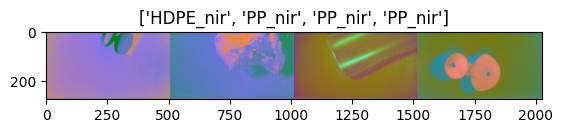

Epoch 0/19
----------


100%|██████████| 1310/1310 [01:15<00:00, 17.30it/s]


train Loss: 1.7355 Acc: 0.3322


100%|██████████| 321/321 [00:09<00:00, 33.13it/s]


val Loss: 1.5718 Acc: 0.3801

Epoch 1/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.52it/s]


train Loss: 1.3816 Acc: 0.5101


100%|██████████| 321/321 [00:09<00:00, 34.48it/s]


val Loss: 1.1812 Acc: 0.5997

Epoch 2/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.58it/s]


train Loss: 1.0113 Acc: 0.6510


100%|██████████| 321/321 [00:09<00:00, 34.52it/s]


val Loss: 0.8815 Acc: 0.6822

Epoch 3/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.59it/s]


train Loss: 0.7765 Acc: 0.7346


100%|██████████| 321/321 [00:09<00:00, 34.54it/s]


val Loss: 0.7424 Acc: 0.7188

Epoch 4/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.53it/s]


train Loss: 0.6223 Acc: 0.7814


100%|██████████| 321/321 [00:09<00:00, 34.37it/s]


val Loss: 0.6870 Acc: 0.7266

Epoch 5/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.55it/s]


train Loss: 0.5205 Acc: 0.8204


100%|██████████| 321/321 [00:09<00:00, 34.52it/s]


val Loss: 0.7130 Acc: 0.7259

Epoch 6/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.54it/s]


train Loss: 0.4312 Acc: 0.8511


100%|██████████| 321/321 [00:09<00:00, 34.38it/s]


val Loss: 0.6122 Acc: 0.7632

Epoch 7/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.52it/s]


train Loss: 0.3840 Acc: 0.8757


100%|██████████| 321/321 [00:09<00:00, 34.26it/s]


val Loss: 0.7707 Acc: 0.7157

Epoch 8/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.55it/s]


train Loss: 0.3745 Acc: 0.8723


100%|██████████| 321/321 [00:09<00:00, 34.59it/s]


val Loss: 0.5682 Acc: 0.7874

Epoch 9/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.56it/s]


train Loss: 0.3755 Acc: 0.8732


100%|██████████| 321/321 [00:09<00:00, 34.32it/s]


val Loss: 0.5981 Acc: 0.7679

Epoch 10/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.52it/s]


train Loss: 0.3627 Acc: 0.8811


100%|██████████| 321/321 [00:09<00:00, 34.39it/s]


val Loss: 0.6360 Acc: 0.7477

Epoch 11/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.56it/s]


train Loss: 0.3455 Acc: 0.8862


100%|██████████| 321/321 [00:09<00:00, 34.35it/s]


val Loss: 0.5818 Acc: 0.7726

Epoch 12/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.53it/s]


train Loss: 0.3444 Acc: 0.8845


100%|██████████| 321/321 [00:09<00:00, 34.30it/s]


val Loss: 0.5628 Acc: 0.7835

Epoch 13/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.50it/s]


train Loss: 0.3384 Acc: 0.8885


100%|██████████| 321/321 [00:09<00:00, 34.50it/s]


val Loss: 0.6577 Acc: 0.7578

Epoch 14/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.58it/s]


train Loss: 0.3293 Acc: 0.8946


100%|██████████| 321/321 [00:09<00:00, 34.46it/s]


val Loss: 0.5924 Acc: 0.7695

Epoch 15/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.52it/s]


train Loss: 0.3265 Acc: 0.8958


100%|██████████| 321/321 [00:09<00:00, 34.47it/s]


val Loss: 0.6539 Acc: 0.7477

Epoch 16/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.52it/s]


train Loss: 0.3258 Acc: 0.8961


100%|██████████| 321/321 [00:09<00:00, 34.18it/s]


val Loss: 0.6035 Acc: 0.7578

Epoch 17/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.58it/s]


train Loss: 0.3378 Acc: 0.8868


100%|██████████| 321/321 [00:09<00:00, 34.26it/s]


val Loss: 0.5748 Acc: 0.7710

Epoch 18/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.55it/s]


train Loss: 0.3386 Acc: 0.8923


100%|██████████| 321/321 [00:09<00:00, 34.34it/s]


val Loss: 0.6901 Acc: 0.7492

Epoch 19/19
----------


100%|██████████| 1310/1310 [01:14<00:00, 17.53it/s]


train Loss: 0.3212 Acc: 0.8992


100%|██████████| 321/321 [00:09<00:00, 34.60it/s]

val Loss: 0.5926 Acc: 0.7804

Training complete in 28m 2s
Best val Acc: 0.787383


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm



mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

# mean = np.array([0, 0, 0])
# std = np.array([1, 1, 1])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((270,504)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((270,504)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


data_dir = '/home/savvas/Desktop/AllDataset/AllDatasetNIR'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)


def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
total_samples = len(image_datasets['train'])

def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase],):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

#model = models.resnet18(pretrained=True)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 7)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=20)

# ResNet 18 with Aris Augmentations Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from tqdm import tqdm



class ImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        super(ImageFolder, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir, name))
            self.data += list(zip(files, [index] * len(files)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_file, label = self.data[index]
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])
        image = np.array(Image.open(os.path.join(root_and_dir, img_file)))

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]

        return image, label




mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


train_transform = A.Compose(
    [
        A.Rotate(limit=45, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.GaussNoise(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.0, hue=0.0, always_apply=False, p=0.5),
        A.Blur(blur_limit=3, p=0.5),
        A.Normalize(
            mean=mean,
            std=std,
            max_pixel_value=255.0
        ),
        A.Resize(256,256),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Normalize(
        mean=mean,
        std=std,
        max_pixel_value=255.0
        ),
        A.Resize(256,256),
        ToTensorV2(),
    ]
)

batch_size = 16
data_dir = 'drive/MyDrive/AllDatasetNIR'

train_set = ImageFolder(root_dir=data_dir+'/train', transform=train_transform)
val_set = ImageFolder(root_dir=data_dir+'/val', transform=val_transform)
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
total_samples = len(train_set)

# for x,y in val_set:
#   print(x.shape,y)

# image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}

# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
#                                              shuffle=True, num_workers=0)
#               for x in ['train', 'val']}




train_size=len(train_set)
val_size=len(val_set)
dataset_sizes={ 'train': train_size , 'val': val_size }

# for x,y in train_set:
#     print(x.shape,y)
# class_names = train_set.classes
# print(class_names)



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# # Get a batch of training data
# inputs, classes = next(iter(train_loader))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        #for phase in ['val']: # and here
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            if phase == 'train':

              for batch_idx, (inputs, labels) in tqdm(enumerate(train_loader),):
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = criterion(outputs, labels)

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          optimizer.zero_grad()
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)

            elif phase == 'val':

              for batch_idx, (inputs, labels) in tqdm(enumerate(val_loader),):
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = criterion(outputs, labels)

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          optimizer.zero_grad()
                          loss.backward()
                          optimizer.step()

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

# model = models.resnet18(pretrained=True)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 7)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# #added for test reasons
# model.load_state_dict(torch.load('drive/MyDrive/modelsAll/ResNet18Aris_NIR'))
# model.eval()
# #until here

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=2)

Epoch 0/1
----------


2it [00:10,  5.33s/it]


KeyboardInterrupt: ignored

# Saving best state of Model

In [ ]:
# model.save(os.path.join('drive/MyDrive/modelsAll','pytorch18RGBfirst.h5')) #saving the model
torch.save(model.state_dict(), '/home/savvas/Desktop/AllDataset/modelsAll/ResNet50_NIR')

# Make Images From 4 Channels To 3 (RGBA TO RGB)

In [ ]:
import PIL.Image
import os
from tempfile import TemporaryFile
from pathlib import Path
import shutil
import matplotlib
import numpy

dirName='/home/savvas/Desktop/AllDataset/AllDatasetVIS/train/MFC_vis/'
files = os.listdir(dirName)
counter=0
for file_name in files:
  if(file_name=='.ipynb_checkpoints'):
    continue
  rgba_image = PIL.Image.open(dirName+file_name)
  rgb_image = rgba_image.convert('RGB')
  rgb_image.save(dirName+file_name)
  #matplotlib.image.imsave(dirName+file_name,rgb_image.numpy().astype("uint8"))

# Calculating HyperSpectral Classifier in tensorflow

In [ ]:
from tensorflow.python.framework.ops import cpp_shape_inference_pb2
import os
from PIL import Image
import keras
import numpy
new_model = load_model(os.path.join('drive/MyDrive/modelsFinal','imageclassifierVIS.h5'))
model2 = load_model(os.path.join('drive/MyDrive/modelsFinal','imageclassifierNIR.h5'))
print("Prediction result:")

wrong_files=np.array([])

def checking_files(dirName,cat,dirName2):
  files = os.listdir(dirName)
  correct = 0
  total = 0
  confR=0
  confW=0
  wrong_files=np.array([])
  pred2=np.array([])
  files2= os.listdir(dirName2)
  for file_name in files2:
    if(file_name=='.ipynb_checkpoints'):
      continue
    image2 = Image.open(dirName2 + "/" + file_name).convert('RGB')
    image2 = image2.resize((504,270))
    image2 = numpy.expand_dims(image2, axis=0)
    image2 = numpy.array(image2)
    image2 = image2/1
    pre2 = model2.predict([image2])
    pred2=np.append(pred2,pre2)
  print(len(pred2) )
  for file_name in files:
      if(file_name=='.ipynb_checkpoints'):
        continue
      total += 1
      image = Image.open(dirName + "/" + file_name).convert('RGB')
      image = image.resize((504,270))
      image = numpy.expand_dims(image, axis=0)
      image = numpy.array(image)
      image = image/1
      pred3 = new_model.predict([image])

      score3 = tf.nn.softmax(pred3)
      score2 = tf.nn.softmax(pred2[(total-1)*4:(total-1)*4+4])
      cat3 = np.argmax(score3)
      cat2 = np.argmax(score2)
      confi3=np.max(score3)
      confi2=np.max(score2)
      confHS = max(confi2,confi3)
      print(cat2,cat3)
      if (cat2==cat3 or confi2>=confi3):
        animals_category=cat2
      else:
        animals_category=cat3
      if (animals_category==cat):
          correct+=1
          confR+=100 * confHS
      else:
        wrong_files=np.append(wrong_files,file_name)
        confW+=100 * confHS
  print("accuracy for RGB: ", (correct/total),correct,total,wrong_files)
  if (total>correct):
    return (correct,total,wrong_files,confR/correct,confW/(total-correct))
  else:
    return (correct,total,wrong_files,confR/correct,0)
cGlass=0
cPlastic=0
cPaper=0
cMetal=0
tGlass=0
tMetal=0
tPlastic=0
tPaper=0
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files('drive/MyDrive/HyperSpectralToyRGB/HS_VIS_val/glass_VIS',0,'drive/MyDrive/HyperSpectralToyRGB/HS_NIR_val/glass_NIR')
wrong_files=np.append(wrong_files,wrongFiles)
CMetal,tMetal,wrongFiles,cRMetal,cWMetal=checking_files('drive/MyDrive/HyperSpectralToyRGB/HS_VIS_val/metal_VIS',1,'drive/MyDrive/HyperSpectralToyRGB/HS_NIR_val/metal_NIR')
wrong_files=np.append(wrong_files,wrongFiles)
cPaper,tPaper,wrongFiles,cRPaper,cWPaper=checking_files('drive/MyDrive/HyperSpectralToyRGB/HS_VIS_val/paper_VIS',2,'drive/MyDrive/HyperSpectralToyRGB/HS_NIR_val/paper_NIR')
wrong_files=np.append(wrong_files,wrongFiles)
cPlastic,tPlastic,wrongFiles,cRPlastic,cWPlastic=checking_files('drive/MyDrive/HyperSpectralToyRGB/HS_VIS_val/plastic_VIS',3,'drive/MyDrive/HyperSpectralToyRGB/HS_NIR_val/plastic_NIR')
wrong_files=np.append(wrong_files,wrongFiles)

# Saving and Loading Arrays

In [ ]:
np.save('drive/MyDrive/wrongFilesNamesWITHPCA_Toy/wrongFileNamesHS_13_03',wrong_files )
arrayA= np.load('drive/MyDrive/wrongFilesNamesWITHPCA_Toy/wrongFileNamesHS.npy')

# printing confidence of every class

In [ ]:
print(cRGlass,cWGlass)
print(cRMetal,cWMetal)
print(cRPaper,cWPaper)
print(cRPlastic,cWPlastic)

# printing average right and wrong confidence

In [ ]:
print((cRGlass+cRMetal+cRPaper+cRPlastic)/4)
print((cWGlass+cWPaper+cWMetal+cWPlastic)/4)

# getting the names of every calss without suffix and sorting them

In [ ]:
import os
from tempfile import TemporaryFile
from pathlib import Path


#thefilenames=np.array([])
dirName='drive/MyDrive/HyperSpectralToyRGB/HS_VIS_/plastic_VIS'
files = os.listdir(dirName)
for file_name in files:
  if(file_name=='.ipynb_checkpoints'):
    continue
  thefilenames=np.append(thefilenames,Path(file_name).stem)


In [ ]:
thefilenames= sorted(thefilenames)
print(thefilenames)
thefilenamesVIS=thefilenames

# Data Augmentation for every class

In [ ]:
import matplotlib
img_height = 270
img_width = 504

data_dir='drive/MyDrive/HyperSpectralToyRGB/HS_VIS'
train_ds2 = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  image_size=(img_height, img_width),
  shuffle=False,
  batch_size=1)

data_augmentation = keras.Sequential([layers.RandomFlip
                  ("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),layers.RandomZoom(0.1),])


counter = 0
for images, _ in train_ds2.take(150):
    counter+=1
    if (counter<27):
      for i in range(9):
        augmented_images = data_augmentation(images)
        matplotlib.image.imsave('glassAug/'+thefilenames[(counter-1)]+'_DA_'+str(i)+'.png', augmented_images[0].numpy().astype("uint8"))
    elif (counter<57):
      for i in range(9):
        augmented_images = data_augmentation(images)
        matplotlib.image.imsave('metalAug/'+thefilenames[(counter-1)]+'_DA_'+str(i)+'.png', augmented_images[0].numpy().astype("uint8"))
    elif (counter<84):
      for i in range(9):
        augmented_images = data_augmentation(images)
        matplotlib.image.imsave('paperAug/'+thefilenames[(counter-1)]+'_DA_'+str(i)+'.png', augmented_images[0].numpy().astype("uint8"))
    else:
      for i in range(9):
        augmented_images = data_augmentation(images)
        matplotlib.image.imsave('plasticAug/'+thefilenames[(counter-1)]+'_DA_'+str(i)+'.png',augmented_images[0].numpy().astype("uint8"))

# functions printPercentages and print_misses

In [ ]:
def printPercentages(GivenClassifier):
  for i in range (17) :
    print(GivenClassifier[i][7])
  for i in range (17) :
    print(GivenClassifier[i][int(GivenClassifier[i][7])])

def print_misses(GivenClassifier):
  misses=np.zeros(7)
  iMisses=0
  percentageWhenRight_Sigouria=0
  percentageWhenWrong=0
  Maximum_classifier= GivenClassifier
  for i in range (0,120):
    mc = int (Maximum_classifier[i][7])
    if (Maximum_classifier[i][7]!=0 and Maximum_classifier[i][7]!=-1):
      misses[iMisses]+=1
      percentageWhenWrong+=Maximum_classifier[i][mc]
    else:
      percentageWhenRight_Sigouria+=Maximum_classifier[i][iMisses]
  iMisses+=1
  for i in range (120,240):
    mc = int (Maximum_classifier[i][7])
    if (Maximum_classifier[i][7]!=1 and Maximum_classifier[i][7]!=-1):
      misses[iMisses]+=1
      percentageWhenWrong+=Maximum_classifier[i][mc]
    else:
      percentageWhenRight_Sigouria+=Maximum_classifier[i][iMisses]
  iMisses+=1
  for i in range (240,348):
    mc = int (Maximum_classifier[i][7])
    if (Maximum_classifier[i][7]!=2 and Maximum_classifier[i][7]!=-1):
      misses[iMisses]+=1
      percentageWhenWrong+=Maximum_classifier[i][mc]
    else:
      percentageWhenRight_Sigouria+=Maximum_classifier[i][iMisses]
  iMisses+=1
  for i in range (348,480):
    mc = int (Maximum_classifier[i][7])
    if (Maximum_classifier[i][7]!=3 and Maximum_classifier[i][7]!=-1):
      misses[iMisses]+=1
      percentageWhenWrong+=Maximum_classifier[i][mc]
    else:
      percentageWhenRight_Sigouria+=Maximum_classifier[i][iMisses]
  iMisses+=1
  for i in range (480,624):
    mc = int (Maximum_classifier[i][7])
    if (Maximum_classifier[i][7]!=4 and Maximum_classifier[i][7]!=-1):
      misses[iMisses]+=1
      percentageWhenWrong+=Maximum_classifier[i][mc]
    else:
      percentageWhenRight_Sigouria+=Maximum_classifier[i][iMisses]
  iMisses+=1
  for i in range (624,972):
    mc = int (Maximum_classifier[i][7] )
    if (Maximum_classifier[i][7]!=5 and Maximum_classifier[i][7]!=-1):
      misses[iMisses]+=1
      percentageWhenWrong+=Maximum_classifier[i][mc]
    else:
      percentageWhenRight_Sigouria+=Maximum_classifier[i][iMisses]
  iMisses+=1
  for i in range (972,1284):
    mc = int (Maximum_classifier[i][7])
    if (Maximum_classifier[i][7]!=6 and Maximum_classifier[i][7]!=-1 ):
      misses[iMisses]+=1
      percentageWhenWrong+=Maximum_classifier[i][mc]
    else:
      percentageWhenRight_Sigouria+=Maximum_classifier[i][iMisses]


  allMistakes=0
  for i in range (7):
    allMistakes+=misses[i]
  accuracy=1-allMistakes/1284
  percentageWhenRight_Sigouria/=(1284-allMistakes)
  percentageWhenWrong/=allMistakes
  print(misses, percentageWhenRight_Sigouria,percentageWhenWrong,accuracy)

<ipython-input-28-310f5dc11538>:94: RuntimeWarning: invalid value encountered in double_scalars
  percentageWhenWrong/=allMistakes


[182.  12.   3.   6.   2.   2.   7.]


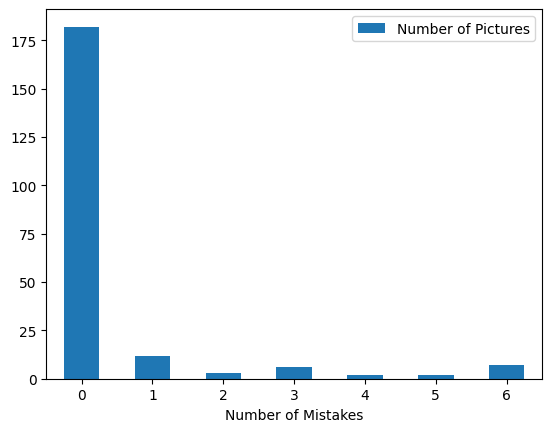

In [ ]:
#Histogram for SumDiv3
import pandas as pd

def printHistogram(GivenClassifier):
  pictureswithNrofMistakes = np.zeros(7) #for the histogram
  helper= np.zeros(7)
  misses=np.zeros(7)
  iMisses=0
  percentageWhenRight_Sigouria=0
  percentageWhenWrong=0
  Maximum_classifier= GivenClassifier
  for i in range (0,120):
    mc = int (Maximum_classifier[i][7])
    helper[mc]+=1
    if ((i+1) % 6==0):
      mistakes=0
      for jelperI in range(7):
        if (0!=jelperI):
            mistakes+=helper[jelperI]
      mistakes=int(mistakes)
      pictureswithNrofMistakes[mistakes]+=1
      helper=np.zeros(7)
  for i in range (120,240):
    mc = int (Maximum_classifier[i][7])
    helper[mc]+=1
    if ((i+1) % 6==0):
      mistakes=0
      for jelperI in range(7):
        if (1!=jelperI):
            mistakes+=helper[jelperI]
      mistakes=int(mistakes)
      pictureswithNrofMistakes[mistakes]+=1
      helper=np.zeros(7)
  for i in range (240,348):
    mc = int (Maximum_classifier[i][7])
    helper[mc]+=1
    if ((i+1) % 6==0):
      mistakes=0
      for jelperI in range(7):
        if (2!=jelperI):
            mistakes+=helper[jelperI]
      mistakes=int(mistakes)
      pictureswithNrofMistakes[mistakes]+=1
      helper=np.zeros(7)
  for i in range (348,480):
    mc = int (Maximum_classifier[i][7])
    helper[mc]+=1
    if ((i+1) % 6==0):
      mistakes=0
      for jelperI in range(7):
        if (3!=jelperI):
            mistakes+=helper[jelperI]
      mistakes=int(mistakes)
      pictureswithNrofMistakes[mistakes]+=1
      helper=np.zeros(7)
  for i in range (480,624):
    mc = int (Maximum_classifier[i][7])
    helper[mc]+=1
    if ((i+1) % 6==0):
      mistakes=0
      for jelperI in range(7):
        if (4!=jelperI):
            mistakes+=helper[jelperI]
      mistakes=int(mistakes)
      pictureswithNrofMistakes[mistakes]+=1
      helper=np.zeros(7)
  for i in range (624,972):
    mc = int (Maximum_classifier[i][7])
    helper[mc]+=1
    if ((i+1) % 6==0):
      mistakes=0
      for jelperI in range(7):
        if (5!=jelperI):
            mistakes+=helper[jelperI]
      mistakes=int(mistakes)
      pictureswithNrofMistakes[mistakes]+=1
      helper=np.zeros(7)
  for i in range (972,1284):
    mc = int (Maximum_classifier[i][7])
    helper[mc]+=1
    if ((i+1) % 6==0):
      mistakes=0
      for jelperI in range(7):
        if (6!=jelperI):
            mistakes+=helper[jelperI]
      mistakes=int(mistakes)
      pictureswithNrofMistakes[mistakes]+=1
      helper=np.zeros(7)
  allMistakes=0
  for i in range (7):
    allMistakes+=misses[i]
  accuracy=1-allMistakes/1284
  percentageWhenRight_Sigouria/=(1284-allMistakes)
  percentageWhenWrong/=allMistakes
  df = pd.DataFrame({'Number of Mistakes':[x for x in range(7)],
                   'Number of Pictures':[x for x in pictureswithNrofMistakes]})
  ax = df.plot.bar(x='Number of Mistakes', y='Number of Pictures', rot=0)
  return pictureswithNrofMistakes
pictureswithNrofMistakes=printHistogram(SumDiv3)
print(pictureswithNrofMistakes)

In [ ]:
print("          Misses per Class             perRight          per Wrong           Accuracy")
print_misses(VIS_classifier)


          Misses per Class             perRight          per Wrong           Accuracy
[3, 4, 5]


# Keeping classifier's results

In [ ]:
from tensorflow.python.framework.ops import cpp_shape_inference_pb2
import os
from PIL import Image

RGB_classifier = np.load('drive/MyDrive/Classifiers/RGB_classifier.npy')
NIR_classifier = np.load('drive/MyDrive/Classifiers/NIR_classifier.npy')
VIS_classifier = np.load('drive/MyDrive/Classifiers/VIS_classifier.npy')
HS_classifier  = np.zeros((1300,8))
Combo1_classifier  = np.zeros((1300,8))
Combo2_classifier  = np.zeros((1300,8))



In [ ]:
wrong_files=np.array([])
confusionMatrix = np.zeros((7,7))
confusionMatrixMajorityVersions = np.zeros((7,7))
wood_plastic = np.zeros((2,2))
wood_plastic_maj = np.zeros((2,2))
def checking_files(dirName,cat):
  files = os.listdir(dirName)
  files= sorted(files)
  correct = 0
  total = 0
  confR=0
  confW=0
  wrong_files=np.array([])
  pred2=np.array([])
  helper= np.zeros(7)
  for file_name in files:
      if(file_name=='.ipynb_checkpoints'):
        continue
      total += 1
      image = Image.open(dirName + "/" + file_name).convert('RGB')
      image = image.resize((504,270))
      image = np.expand_dims(image, axis=0)
      image = np.array(image)
      image = image/1
      pred3 = new_model.predict([image])
      score3 = tf.nn.softmax(pred3[0])
      cat3 = np.argmax(score3)
      confi3=np.max(score3)
      animals_category=cat3
      a=np.array(score3)
      print(a)
      print("total:"+str(total%6) + file_name)
      RGB_classifier[total-1][0]=a[0]
      RGB_classifier[total-1][1]=a[1]
      RGB_classifier[total-1][2]=a[2]
      RGB_classifier[total-1][3]=cat3
      helper[animals_category]+=1
      confusionMatrix[cat][animals_category]+=1
      if ((total) % 6==0):
        print(file_name)
        majority_cat=np.argmax(helper)
        helper=np.zeros(7)
        confusionMatrixMajorityVersions[cat][majority_cat]+=1
        if (majority_cat==cat):
            #if it is wood
            if(cat>1 and cat<5):
              wood_plastic_maj[0][0]+=1
            else:
              wood_plastic_maj[1][1]+=1
        else:
          if(cat>1 and cat<5 and majority_cat>1 and majority_cat<5):
              wood_plastic_maj[0][0]+=1
          elif(cat!=2 and cat!=3 and cat!=4 and majority_cat!=2 and majority_cat!=3 and majority_cat!=4 ):
              wood_plastic_maj[1][1]+=1
          elif(cat>1 and cat<5 and (majority_cat<=1 or majority_cat>=5)):
            wood_plastic_maj[0][1]+=1
          else:
              wood_plastic_maj[1][0]+=1
      if (animals_category==cat):
          correct+=1
          confR+=100 * confi3
          #if it is wood
          if(cat>1 and cat<5):
            wood_plastic[0][0]+=1
          else:
            wood_plastic[1][1]+=1
      else:
        wrong_files=np.append(wrong_files,file_name)
        confW+=100 * confi3
        if(cat>1 and cat<5 and animals_category>1 and animals_category<5):
            wood_plastic[0][0]+=1
        elif(cat!=2 and cat!=3 and cat!=4 and animals_category!=2 and animals_category!=3 and animals_category!=4 ):
            wood_plastic[1][1]+=1
        elif(cat>1 and cat<5 and (animals_category<=1 or animals_category>=5)):
            wood_plastic[0][1]+=1
        else:
            wood_plastic[1][0]+=1
  print("accuracy for RGB: ", (correct/total),correct,total,wrong_files)
  if (total>correct):
    return (correct,total,wrong_files,confR/correct,confW/(total-correct))
  else:
    return (correct,total,wrong_files,confR/correct,0)

cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files('drive/MyDrive/AllDatasetNIR/AllDatasetNIR_val/HDPE_nir',0)
wrong_files=np.append(wrong_files,wrongFiles)
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files('drive/MyDrive/AllDatasetNIR/AllDatasetNIR_val/LDPE_nir',1)
wrong_files=np.append(wrong_files,wrongFiles)
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files('drive/MyDrive/AllDatasetNIR/AllDatasetNIR_val/MDF_nir',2)
wrong_files=np.append(wrong_files,wrongFiles)
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files('drive/MyDrive/AllDatasetNIR/AllDatasetNIR_val/MFC_nir',3)
wrong_files=np.append(wrong_files,wrongFiles)
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files('drive/MyDrive/AllDatasetNIR/AllDatasetNIR_val/OAK_nir',4)
wrong_files=np.append(wrong_files,wrongFiles)
CMetal,tMetal,wrongFiles,cRMetal,cWMetal=checking_files('drive/MyDrive/AllDatasetNIR/AllDatasetNIR_val/PET_nir',5)
wrong_files=np.append(wrong_files,wrongFiles)
cPaper,tPaper,wrongFiles,cRPaper,cWPaper=checking_files('drive/MyDrive/AllDatasetNIR/AllDatasetNIR_val/PP_nir',6)
wrong_files=np.append(wrong_files,wrongFiles)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.save('drive/MyDrive/modelsAll/WF_nir',wrong_files )

In [ ]:
#Combination1: First Hyperspectral and then HS + RGB

for i in range (1284):
  if (NIR_classifier[i][7]==VIS_classifier[i][7]):
    mc = int(NIR_classifier[i][7] )
    HS_classifier[i][7] = mc
    #keep the largest percentage for the next comparison
    HS_classifier[i][mc] =max(NIR_classifier[i][mc] , VIS_classifier[i][mc] )
  else:
    mcN = int(NIR_classifier[i][7])
    mcV = int(VIS_classifier[i][7])
    if (NIR_classifier[i][mcN]>VIS_classifier[i][mcV]):
      HS_classifier[i][7]=mcN
      HS_classifier[i][mcN]=NIR_classifier[i][mcN]
    else:
      HS_classifier[i][7]=mcV
      HS_classifier[i][mcV]=VIS_classifier[i][mcV]
#HS_classifier is ready
#same process for the Combo1_classifier
for i in range (1284):
  if (HS_classifier[i][7]==RGB_classifier[i][7]):
    mc = int(HS_classifier[i][7] )
    Combo1_classifier[i][7] = mc
    #keep the largest percentage for the next comparison
    Combo1_classifier[i][mc] =max(HS_classifier[i][mc] , RGB_classifier[i][mc] )
  else:
    mcR = int(RGB_classifier[i][7])
    mcH = int(HS_classifier[i][7])
    if (RGB_classifier[i][mcR]>HS_classifier[i][mcH]):
      Combo1_classifier[i][7]=mcR
      Combo1_classifier[i][mcR]=RGB_classifier[i][mcR]
    else:
      Combo1_classifier[i][7]=mcH
      Combo1_classifier[i][mcH]=HS_classifier[i][mcH]
#Combo1_classifier is ready

In [ ]:
#Combination2: All together NIR+VIS+RGB
for i in range (1284):
  if (NIR_classifier[i][7]==VIS_classifier[i][7] and RGB_classifier[i][7]==VIS_classifier[i][7] ):
    mc = int(NIR_classifier[i][7])
    Combo2_classifier[i][7] = mc
    #keep the largest percentage
    Combo2_classifier[i][mc] =max(NIR_classifier[i][mc] , VIS_classifier[i][mc], RGB_classifier[i][mc] )
  elif (NIR_classifier[i][7]==VIS_classifier[i][7]):
    mc = int(NIR_classifier[i][7] )
    Combo2_classifier[i][7] = mc
    #keep the largest percentage
    Combo2_classifier[i][mc] =max(NIR_classifier[i][mc] , VIS_classifier[i][mc])
  elif(RGB_classifier[i][7]==VIS_classifier[i][7]):
    mc = int(RGB_classifier[i][7] )
    Combo2_classifier[i][7] = mc
    #keep the largest percentage
    Combo2_classifier[i][mc] =max(RGB_classifier[i][mc] , VIS_classifier[i][mc])
  elif(RGB_classifier[i][7]==NIR_classifier[i][7]):
    mc = int(RGB_classifier[i][7] )
    Combo2_classifier[i][7] = mc
    #keep the largest percentage
    Combo2_classifier[i][mc] =max(RGB_classifier[i][mc] , NIR_classifier[i][mc])
  else: #kai oi 7 classifiers deixnoyn diaforetiki klassi, idio me maximum_classifier edw
    mc1=int(VIS_classifier[i][7])
    mc2=int(NIR_classifier[i][7])
    mc7=int(RGB_classifier[i][7])
    a = max(VIS_classifier[i][mc1] , RGB_classifier[i][mc7], NIR_classifier[i][mc2])
    if (a==VIS_classifier[i][mc1]):
      Combo2_classifier[i][7] = mc1
      Combo2_classifier[i][mc1] = a
    elif  (a==RGB_classifier[i][mc7]):
      Combo2_classifier[i][7] = mc7
      Combo2_classifier[i][mc7] = a
    else:
      Combo2_classifier[i][7] = mc2
      Combo2_classifier[i][mc2] = a


#Combo2_classifier is ready

In [ ]:
#Unanimous Voting: all classifiers must predict the same or else no prediction is made
Unanimous  = np.zeros((1300,8))

for i in range (1284):
  if (VIS_classifier[i][7]==RGB_classifier[i][7] and NIR_classifier[i][7]== RGB_classifier[i][7] ):
    mc= int(RGB_classifier[i][7])
    Unanimous[i][7] = mc
    #keep the largest percentage for the next comparison
    Unanimous[i][mc] = max(VIS_classifier[i][mc] , RGB_classifier[i][mc], NIR_classifier[i][mc] )
    #or /3
    Unanimous[i][mc] = (VIS_classifier[i][mc] + RGB_classifier[i][mc] + NIR_classifier[i][mc] ) /3
  else:
    Unanimous[i][7] = -1
#Unanimous is ready

misWhenAlltheSame=0
if (Unanimous[i][7]!=-1 ) :
  misWhenAlltheSame+=1

In [ ]:
#Weighted Voting: e.g. rgb classifier >=< 1.3 * HS3
#edw 8a prepei na exoyme tsekarei an kapoios classifier leitourgei kalitera
#o vis leitourgei kalytera 80.2/48.8 = 1.643

ComboW_classifier  = np.zeros((1300,8))
# HS2_classifier = np.zeros((17,4))
# for i in range (1284):
#   for j in range (7):
#     HS2_classifier[i][j]=((VIS_classifier[i][j]+ NIR_classifier[i][j])/2)
#   HS2_classifier[i][3]= np.argmax(HS2_classifier[i])
# #HS2_classifier is ready

#edw pairnoyme HS3 epd douleyei kalytera
HS3_classifier=HS_classifier
for i in range (1284):
  if (HS3_classifier[i][7]==RGB_classifier[i][7]):
    mc = int(HS3_classifier[i][7] )
    ComboW_classifier[i][7] = mc
    ComboW_classifier[i][mc] =max(HS3_classifier[i][mc] , RGB_classifier[i][mc] )
  else:
    mcR = int(RGB_classifier[i][7])
    mcH = int(HS3_classifier[i][7])
    if (1.125*RGB_classifier[i][mcR] > HS3_classifier[i][mcH]):
      ComboW_classifier[i][7]=mcR
      ComboW_classifier[i][mcR]=RGB_classifier[i][mcR]
    else:
      ComboW_classifier[i][7]=mcH
      ComboW_classifier[i][mcH]=HS3_classifier[i][mcH]
#ComboW_classifier is ready

In [ ]:
SumDiv3 = np.zeros((1300,8))
for i in range (1284):
  for j in range (7):
    mc=j
    SumDiv3[i][mc] = (VIS_classifier[i][mc] + RGB_classifier[i][mc] + NIR_classifier[i][mc] )/3
  SumDiv3[i][7]= np.argmax(SumDiv3[i])

In [ ]:
Maximum_classifier = np.zeros((1300,8))

for i in range (0,1284):
  mc1=int(VIS_classifier[i][7])
  mc2=int(NIR_classifier[i][7])
  mc3=int(RGB_classifier[i][7])
  a = max(VIS_classifier[i][mc1] , RGB_classifier[i][mc3], NIR_classifier[i][mc2])
  if (a==VIS_classifier[i][mc1]):
    Maximum_classifier[i][7] = mc1
    Maximum_classifier[i][mc1] = a
  elif  (a==RGB_classifier[i][mc3]):
    Maximum_classifier[i][7] = mc3
    Maximum_classifier[i][mc3] = a
  else:
    Maximum_classifier[i][7] = mc2
    Maximum_classifier[i][mc2] = a

#Print the wrongs in VIS

In [ ]:
arrayA =np.load('drive/MyDrive/Classifiers/wrongFilesVIS.npy')
print(arrayA)

['HDPE_vis_001.png' 'HDPE_vis_001_DA_0.png' 'HDPE_vis_001_DA_1.png'
 'HDPE_vis_001_DA_2.png' 'HDPE_vis_001_DA_3.png' 'HDPE_vis_001_DA_4.png'
 'HDPE_vis_007.png' 'HDPE_vis_007_DA_1.png' 'HDPE_vis_007_DA_3.png'
 'HDPE_vis_007_DA_4.png' 'HDPE_vis_009_DA_0.png' 'HDPE_vis_009_DA_1.png'
 'HDPE_vis_009_DA_2.png' 'HDPE_vis_009_DA_4.png' 'HDPE_vis_011_DA_0.png'
 'HDPE_vis_011_DA_1.png' 'HDPE_vis_011_DA_2.png' 'HDPE_vis_011_DA_4.png'
 'HDPE_vis_012_DA_2.png' 'HDPE_vis_013_DA_1.png' 'HDPE_vis_013_DA_2.png'
 'HDPE_vis_013_DA_4.png' 'HDPE_vis_017.png' 'HDPE_vis_017_DA_0.png'
 'HDPE_vis_017_DA_1.png' 'HDPE_vis_017_DA_2.png' 'HDPE_vis_017_DA_3.png'
 'HDPE_vis_017_DA_4.png' 'HDPE_vis_018.png' 'HDPE_vis_018_DA_0.png'
 'HDPE_vis_018_DA_1.png' 'HDPE_vis_018_DA_2.png' 'HDPE_vis_018_DA_3.png'
 'HDPE_vis_018_DA_4.png' 'HDPE_vis_019.png' 'HDPE_vis_019_DA_0.png'
 'HDPE_vis_019_DA_1.png' 'HDPE_vis_019_DA_2.png' 'HDPE_vis_019_DA_3.png'
 'HDPE_vis_019_DA_4.png' 'LDPE_vis_001.png' 'LDPE_vis_001_DA_0.png'
 'LDPE_v

# PyTorch keeping classifier's results  - ResNet50


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import numpy
from PIL import Image
import io

RGB_classifier = np.zeros((1300,8))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
model = model.to(device)
#Moving on

model.load_state_dict(torch.load('drive/MyDrive/modelsAll/ResNet50_VIS'))
model.eval()

wrong_files=np.array([])
confusionMatrix = np.zeros((7,7))
confusionMatrixMajorityVersions = np.zeros((7,7))
wood_plastic = np.zeros((2,2))
wood_plastic_maj = np.zeros((2,2))
pictureswithNrofMistakes = np.zeros(7) #for the histogram
majorityCorrects = np.zeros(7)

def checking_files(dirName,cat,total):
  files = os.listdir(dirName)
  files= sorted(files)
  correct = 0
  confR=0
  confW=0
  wrong_files=np.array([])
  pred2=np.array([])
  helper= np.zeros(7)
  for file_name in files:
      if(file_name=='.ipynb_checkpoints'):
        continue
      total += 1
      img = Image.open(dirName+'/'+file_name)
      transform_norm = transforms.Compose([
          transforms.Resize((270,504)),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])
      img_normalized = transform_norm(img).float()
      img_normalized = img_normalized.unsqueeze_(0)
      img_normalized = img_normalized.to(device)
      with torch.no_grad():
          model.eval()
          outputs =model(img_normalized)
          probs = torch.nn.functional.softmax(outputs, dim=1)
          na = probs.to('cpu').numpy()
          _, preds = torch.max(outputs, 1)
          print(preds)
          na_preds= preds.to('cpu').numpy()
          RGB_classifier[total-1,0:7] = na
          RGB_classifier[total-1,7] = na_preds
          animals_category=na_preds
      helper[animals_category]+=1
      confusionMatrix[cat][animals_category]+=1
      if ((total) % 6==0):
        print(file_name)
        mistakes=0
        for jelperI in range(7):
          if (cat!=jelperI):
            mistakes+=helper[jelperI]
            mistakes=int(mistakes)
        pictureswithNrofMistakes[mistakes]+=1
        majority_cat=np.argmax(helper)
        helper=np.zeros(7)
        confusionMatrixMajorityVersions[cat][majority_cat]+=1
        if (majority_cat==cat):
            majorityCorrects[cat]+=1
            #if it is wood
            if(cat>1 and cat<5):
              wood_plastic_maj[0][0]+=1
            else:
              wood_plastic_maj[1][1]+=1
        else:
          if(cat>1 and cat<5 and majority_cat>1 and majority_cat<5):
              wood_plastic_maj[0][0]+=1
          elif(cat!=2 and cat!=3 and cat!=4 and majority_cat!=2 and majority_cat!=3 and majority_cat!=4 ):
              wood_plastic_maj[1][1]+=1
          elif(cat>1 and cat<5 and (majority_cat<=1 or majority_cat>=5)):
            wood_plastic_maj[0][1]+=1
          else:
              wood_plastic_maj[1][0]+=1
      if (animals_category==cat):
          correct+=1
          confR+=100 * na_preds
          #if it is wood
          if(cat>1 and cat<5):
            wood_plastic[0][0]+=1
          else:
            wood_plastic[1][1]+=1
      else:
        wrong_files=np.append(wrong_files,file_name)
        confW+=100 * na_preds
        if(cat>1 and cat<5 and animals_category>1 and animals_category<5):
            wood_plastic[0][0]+=1
        elif(cat!=2 and cat!=3 and cat!=4 and animals_category!=2 and animals_category!=3 and animals_category!=4 ):
            wood_plastic[1][1]+=1
        elif(cat>1 and cat<5 and (animals_category<=1 or animals_category>=5)):
            wood_plastic[0][1]+=1
        else:
            wood_plastic[1][0]+=1
  print("accuracy for RGB: ", (correct/total),correct,total,wrong_files)
  if (total>correct):
    return (correct,total,wrong_files,confR/correct,confW/(total-correct))
  else:
    return (correct,total,wrong_files,confR/correct,0)

directoryName = 'drive/MyDrive/AllDatasetVIS/val/'
dirSuffix ='_vis'

total=0
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'HDPE'+dirSuffix,0,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'LDPE'+dirSuffix,1,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'MDF'+dirSuffix,2,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'MFC'+dirSuffix,3,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'OAK'+dirSuffix,4,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
CMetal,tMetal,wrongFiles,cRMetal,cWMetal=checking_files(directoryName+'PET'+dirSuffix,5,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tMetal
cPaper,tPaper,wrongFiles,cRPaper,cWPaper=checking_files(directoryName+'PP'+dirSuffix,6,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tPaper

tensor([6], device='cuda:0')
tensor([5], device='cuda:0')
tensor([5], device='cuda:0')
tensor([6], device='cuda:0')
tensor([6], device='cuda:0')
tensor([5], device='cuda:0')
HDPE_vis_001_DA_4.png
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
HDPE_vis_002_DA_4.png
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
HDPE_vis_003_DA_4.png
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
HDPE_vis_004_DA_4.png
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
tensor([0], device='cuda:0')
HDPE_vis_005_DA_4.png
tensor([0], device='

In [ ]:
totalCorrects=0
for i in range (7):
  totalCorrects+=majorityCorrects[i]
print("majority Accuracy is " + str(totalCorrects/214))

majority Accuracy is 0.7990654205607477


In [ ]:
#print(RGB_classifier[600:650,7])
np.save('drive/MyDrive/Classifiers/VIS_classifier',RGB_classifier )
np.save('drive/MyDrive/Classifiers/wrongFilesVIS',wrong_files )

#arrayA= np.load('drive/MyDrive/Classifiers/RGB_classifier.npy')
print(RGB_classifier[0:120,:])
counter =0
for i in range (18*6):
  if RGB_classifier[240+i,7]==2:
    counter+=1
print(counter)

[[2.86697388e-01 4.18625632e-06 8.94295343e-04 2.64162687e-03
  5.48562525e-07 5.10691851e-02 6.58692777e-01 6.00000000e+00]
 [1.14162862e-01 2.19554067e-06 2.35010899e-04 6.88959798e-03
  1.21105685e-07 4.51006681e-01 4.27703500e-01 5.00000000e+00]
 [1.11114696e-01 1.14056206e-06 9.81197954e-05 2.45354953e-03
  2.45456153e-08 6.64500952e-01 2.21831575e-01 5.00000000e+00]
 [1.41401693e-01 2.09978134e-06 3.80697573e-04 3.88851040e-03
  1.06208006e-07 3.78012657e-01 4.76314217e-01 6.00000000e+00]
 [1.35701209e-01 1.77835159e-06 4.44138539e-04 1.79138780e-03
  5.54360930e-08 3.12003195e-01 5.50058305e-01 6.00000000e+00]
 [1.58414975e-01 2.00677209e-06 9.21001629e-05 2.31582532e-03
  3.78950773e-08 4.23384309e-01 4.15790647e-01 5.00000000e+00]
 [9.14058983e-01 1.67901962e-04 4.62398020e-05 5.67867173e-05
  6.30546629e-06 1.85814258e-02 6.70823231e-02 0.00000000e+00]
 [8.77682090e-01 3.32211726e-04 1.25805134e-04 7.33473498e-05
  1.85885638e-05 2.97092404e-02 9.20586586e-02 0.00000000e+00]


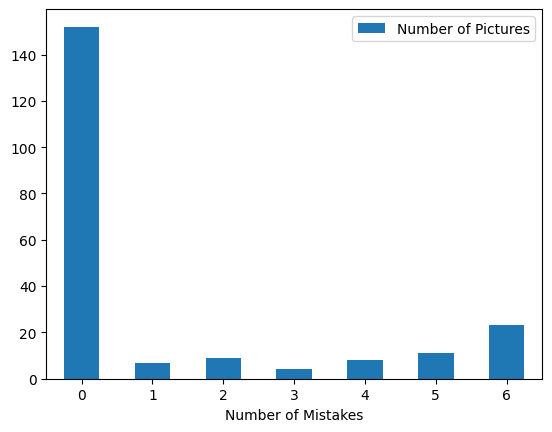

In [ ]:
import pandas as pd
df = pd.DataFrame({'Number of Mistakes':[x for x in range(7)],
                   'Number of Pictures':[x for x in pictureswithNrofMistakes]})
ax = df.plot.bar(x='Number of Mistakes', y='Number of Pictures', rot=0)

# plt.hist(pictureswithNrofMistakes,cumulative=-1)

# PyTorch keeping classifier's results  - ResNet18 Aris

In [ ]:
import albumentations as A
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import numpy
from PIL import Image
import io
from fastai.vision.all import *

RGB_classifier = np.zeros((1300,8))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
model = model.to(device)
model.load_state_dict(torch.load('drive/MyDrive/modelsAll/ResNet18Aris_VIS'))
model.eval()

wrong_files=np.array([])
confusionMatrix = np.zeros((7,7))
confusionMatrixMajorityVersions = np.zeros((7,7))
wood_plastic = np.zeros((2,2))
wood_plastic_maj = np.zeros((2,2))
pictureswithNrofMistakes = np.zeros(7) #for the histogram
majorityCorrects = np.zeros(7)


aug = A.Compose(
    [
        A.Normalize(
        mean=mean,
        std=std,
        max_pixel_value=255.0
        ),
        A.Resize(270,504),
        ToTensorV2(),
    ])
def aug_tfm(img):
    np_img = np.array(img)
    aug_img = aug(image=np_img)['image']
    return aug_img

def checking_files(dirName,cat,total):
  files = os.listdir(dirName)
  files= sorted(files)
  correct = 0
  confR=0
  confW=0
  wrong_files=np.array([])
  pred2=np.array([])
  helper= np.zeros(7)
  for file_name in files:
      if(file_name=='.ipynb_checkpoints'):
        continue
      total += 1
      img = Image.open(dirName+'/'+file_name)

      transform_norm = transforms.Compose([
          transforms.Resize((270,504)),
          transforms.ToTensor(),
          transforms.Normalize(mean, std)
      ])
      img_normalized = aug_tfm(img).float()
      img_normalized = img_normalized.unsqueeze_(0)
      img_normalized = img_normalized.to(device)
      with torch.no_grad():
          model.eval()
          outputs =model(img_normalized)
          probs = torch.nn.functional.softmax(outputs, dim=1)
          na = probs.to('cpu').numpy()
          _, preds = torch.max(outputs, 1)
          print(preds)
          na_preds= preds.to('cpu').numpy()
          RGB_classifier[total-1,0:7] = na
          RGB_classifier[total-1,7] = na_preds
          animals_category=na_preds
      helper[animals_category]+=1
      confusionMatrix[cat][animals_category]+=1
      if ((total) % 6==0):
        print(file_name)
        mistakes=0
        for jelperI in range(7):
          if (cat!=jelperI):
            mistakes+=helper[jelperI]
            mistakes=int(mistakes)
        pictureswithNrofMistakes[mistakes]+=1
        majority_cat=np.argmax(helper)
        helper=np.zeros(7)
        confusionMatrixMajorityVersions[cat][majority_cat]+=1
        if (majority_cat==cat):
            majorityCorrects[cat]+=1
            #if it is wood
            if(cat>1 and cat<5):
              wood_plastic_maj[0][0]+=1
            else:
              wood_plastic_maj[1][1]+=1
        else:
          if(cat>1 and cat<5 and majority_cat>1 and majority_cat<5):
              wood_plastic_maj[0][0]+=1
          elif(cat!=2 and cat!=3 and cat!=4 and majority_cat!=2 and majority_cat!=3 and majority_cat!=4 ):
              wood_plastic_maj[1][1]+=1
          elif(cat>1 and cat<5 and (majority_cat<=1 or majority_cat>=5)):
            wood_plastic_maj[0][1]+=1
          else:
              wood_plastic_maj[1][0]+=1
      if (animals_category==cat):
          correct+=1
          confR+=100 * na_preds
          #if it is wood
          if(cat>1 and cat<5):
            wood_plastic[0][0]+=1
          else:
            wood_plastic[1][1]+=1
      else:
        wrong_files=np.append(wrong_files,file_name)
        confW+=100 * na_preds
        if(cat>1 and cat<5 and animals_category>1 and animals_category<5):
            wood_plastic[0][0]+=1
        elif(cat!=2 and cat!=3 and cat!=4 and animals_category!=2 and animals_category!=3 and animals_category!=4 ):
            wood_plastic[1][1]+=1
        elif(cat>1 and cat<5 and (animals_category<=1 or animals_category>=5)):
            wood_plastic[0][1]+=1
        else:
            wood_plastic[1][0]+=1
  print("accuracy for RGB: ", (correct/total),correct,total,wrong_files)
  if (total>correct):
    return (correct,total,wrong_files,confR/(correct+1),confW/(total-correct))
  else:
    return (correct,total,wrong_files,confR/(correct+1),0)

directoryName = 'drive/MyDrive/AllDatasetVIS/val/'
dirSuffix ='_vis'

total=0
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'HDPE'+dirSuffix,0,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'LDPE'+dirSuffix,1,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'MDF'+dirSuffix,2,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'MFC'+dirSuffix,3,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'OAK'+dirSuffix,4,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
CMetal,tMetal,wrongFiles,cRMetal,cWMetal=checking_files(directoryName+'PET'+dirSuffix,5,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tMetal
cPaper,tPaper,wrongFiles,cRPaper,cWPaper=checking_files(directoryName+'PP'+dirSuffix,6,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tPaper

tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([1], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
HDPE_vis_001_DA_4.png
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
HDPE_vis_002_DA_4.png
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([1], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
HDPE_vis_003_DA_4.png
tensor([1], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([1], device='cuda:0')
tensor([3], device='cuda:0')
HDPE_vis_004_DA_4.png
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
tensor([1], device='cuda:0')
HDPE_vis_005_DA_4.png
tensor([1], device='

# Confusion Matrices

[[ 64.   0.]
 [  0. 150.]]
[[384.   0.]
 [  3. 897.]]


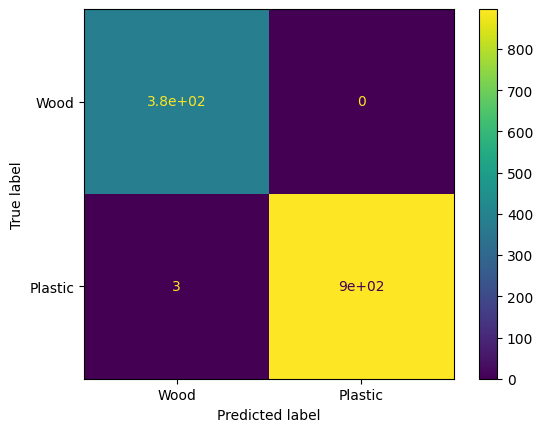

In [ ]:
print(wood_plastic_maj)
print(wood_plastic)
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = wood_plastic, display_labels = ["Wood", "Plastic"])
cm_display.plot()
plt.show()

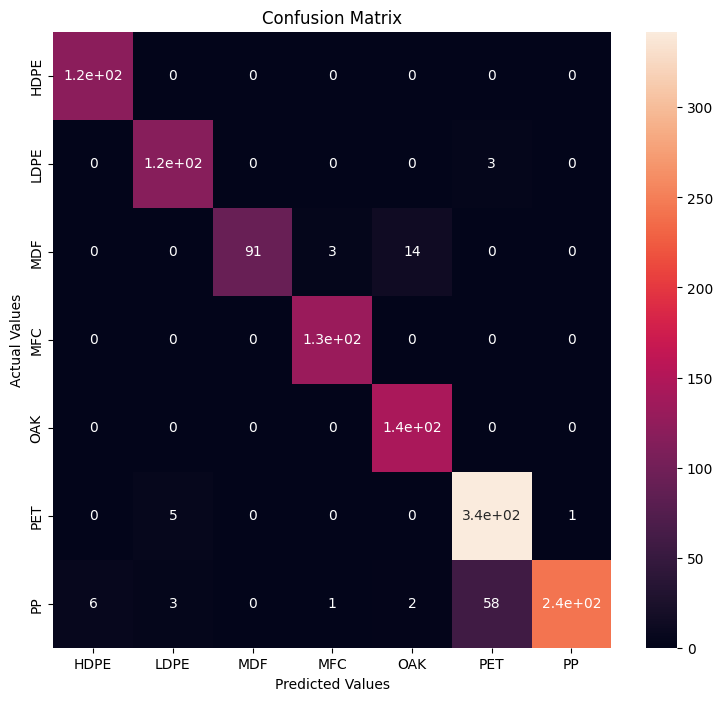

In [ ]:
from sklearn import metrics
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
display_labels = ["HDPE", "LDPE","MDF","MFC","OAK","PET","PP"]
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, )
cm = confusionMatrix
cm_df = pd.DataFrame(cm,
                     index = display_labels,
                     columns = display_labels)
plt.figure(figsize=(9,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#Sum Classifier + swapping rows and columns

In [ ]:
newArr=confusionMatrixMajorityVersions
newArr[[0, 2]] = newArr[[2, 0]]
newArr[[1, 3]] = newArr[[3, 1]]
newArr[[2, 4]] = newArr[[4, 2]]
newArr[:, [2, 0]] = newArr[:, [0, 2]]
newArr[:, [3, 1]] = newArr[:, [1, 3]]
newArr[:, [4, 2]] = newArr[:, [2, 4]]

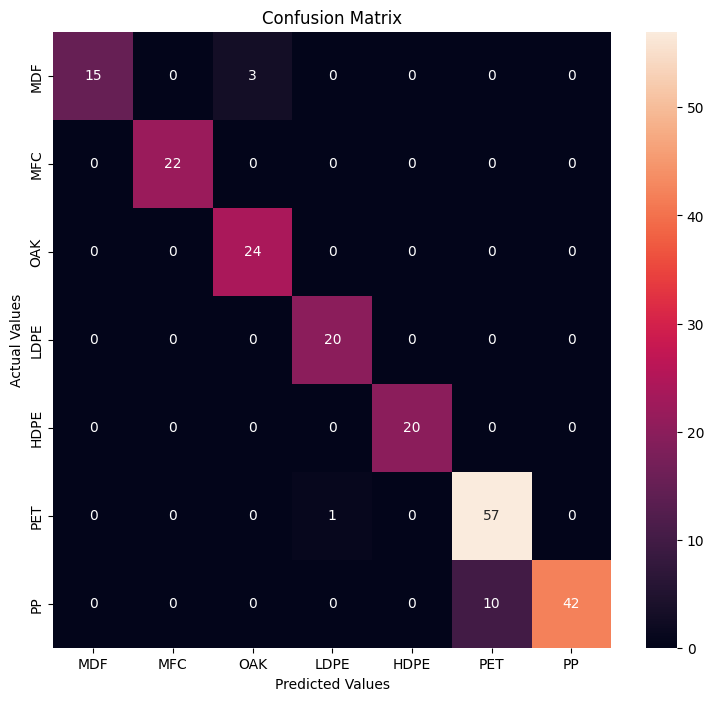

In [ ]:
from sklearn import metrics
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
display_labels = ["MDF", "MFC","OAK","LDPE","HDPE","PET","PP"]
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, )
cm = confusionMatrixMajorityVersions
cm_df = pd.DataFrame(cm,
                     index = display_labels,
                     columns = display_labels)
plt.figure(figsize=(9,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import numpy
from PIL import Image
import io

RGB_classifier = SumDiv3

wrong_files=np.array([])
confusionMatrix = np.zeros((7,7))
confusionMatrixMajorityVersions = np.zeros((7,7))
wood_plastic = np.zeros((2,2))
wood_plastic_maj = np.zeros((2,2))
pictureswithNrofMistakes = np.zeros(7) #for the histogram
majorityCorrects = np.zeros(7)

def checking_files(dirName,cat,total):
  files = os.listdir(dirName)
  files= sorted(files)
  correct = 0
  confR=0
  confW=0
  wrong_files=np.array([])
  pred2=np.array([])
  helper= np.zeros(7)
  for file_name in files:
      if(file_name=='.ipynb_checkpoints'):
        continue
      total += 1
      animals_category=int(RGB_classifier[total-1,7])
      helper[animals_category]+=1
      confusionMatrix[cat][animals_category]+=1
      if ((total) % 6==0):
        print(file_name)
        mistakes=0
        for jelperI in range(7):
          if (cat!=jelperI):
            mistakes+=helper[jelperI]
            mistakes=int(mistakes)
        pictureswithNrofMistakes[mistakes]+=1
        majority_cat=np.argmax(helper)
        helper=np.zeros(7)
        confusionMatrixMajorityVersions[cat][majority_cat]+=1
        if (majority_cat==cat):
            majorityCorrects[cat]+=1
            #if it is wood
            if(cat>1 and cat<5):
              wood_plastic_maj[0][0]+=1
            else:
              wood_plastic_maj[1][1]+=1
        else:
          if(cat>1 and cat<5 and majority_cat>1 and majority_cat<5):
              wood_plastic_maj[0][0]+=1
          elif(cat!=2 and cat!=3 and cat!=4 and majority_cat!=2 and majority_cat!=3 and majority_cat!=4 ):
              wood_plastic_maj[1][1]+=1
          elif(cat>1 and cat<5 and (majority_cat<=1 or majority_cat>=5)):
            wood_plastic_maj[0][1]+=1
          else:
              wood_plastic_maj[1][0]+=1
      if (animals_category==cat):
          correct+=1
          confR+=100 * RGB_classifier[total-1,7]
          #if it is wood
          if(cat>1 and cat<5):
            wood_plastic[0][0]+=1
          else:
            wood_plastic[1][1]+=1
      else:
        wrong_files=np.append(wrong_files,file_name)
        confW+=100 * RGB_classifier[total-1,7]
        if(cat>1 and cat<5 and animals_category>1 and animals_category<5):
            wood_plastic[0][0]+=1
        elif(cat!=2 and cat!=3 and cat!=4 and animals_category!=2 and animals_category!=3 and animals_category!=4 ):
            wood_plastic[1][1]+=1
        elif(cat>1 and cat<5 and (animals_category<=1 or animals_category>=5)):
            wood_plastic[0][1]+=1
        else:
            wood_plastic[1][0]+=1
  print("accuracy for RGB: ", (correct/total),correct,total,wrong_files)
  if (total>correct):
    return (correct,total,wrong_files,confR/correct,confW/(total-correct))
  else:
    return (correct,total,wrong_files,confR/correct,0)

directoryName = 'drive/MyDrive/AllDatasetVIS/val/'
dirSuffix ='_vis'

total=0
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'HDPE'+dirSuffix,0,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'LDPE'+dirSuffix,1,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'MDF'+dirSuffix,2,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'MFC'+dirSuffix,3,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
cGlass,tGlass,wrongFiles,cRGlass,cWGlass=checking_files(directoryName+'OAK'+dirSuffix,4,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tGlass
CMetal,tMetal,wrongFiles,cRMetal,cWMetal=checking_files(directoryName+'PET'+dirSuffix,5,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tMetal
cPaper,tPaper,wrongFiles,cRPaper,cWPaper=checking_files(directoryName+'PP'+dirSuffix,6,total)
wrong_files=np.append(wrong_files,wrongFiles)
total=tPaper

HDPE_vis_001_DA_4.png
HDPE_vis_002_DA_4.png
HDPE_vis_003_DA_4.png
HDPE_vis_004_DA_4.png
HDPE_vis_005_DA_4.png
HDPE_vis_006_DA_4.png
HDPE_vis_007_DA_4.png
HDPE_vis_008_DA_4.png
HDPE_vis_009_DA_4.png
HDPE_vis_010_DA_4.png
HDPE_vis_011_DA_4.png
HDPE_vis_012_DA_4.png
HDPE_vis_013_DA_4.png
HDPE_vis_014_DA_4.png
HDPE_vis_015_DA_4.png
HDPE_vis_016_DA_4.png
HDPE_vis_017_DA_4.png
HDPE_vis_018_DA_4.png
HDPE_vis_019_DA_4.png
HDPE_vis_020_DA_4.png
accuracy for RGB:  1.0 120 120 []
LDPE_vis_001_DA_4.png
LDPE_vis_002_DA_4.png
LDPE_vis_003_DA_4.png
LDPE_vis_004_DA_4.png
LDPE_vis_005_DA_4.png
LDPE_vis_006_DA_4.png
LDPE_vis_007_DA_4.png
LDPE_vis_008_DA_4.png
LDPE_vis_009_DA_4.png
LDPE_vis_010_DA_4.png
LDPE_vis_011_DA_4.png
LDPE_vis_012_DA_4.png
LDPE_vis_013_DA_4.png
LDPE_vis_014_DA_4.png
LDPE_vis_015_DA_4.png
LDPE_vis_016_DA_4.png
LDPE_vis_017_DA_4.png
LDPE_vis_018_DA_4.png
LDPE_vis_019_DA_4.png
LDPE_vis_020_DA_4.png
accuracy for RGB:  0.4875 117 240 ['LDPE_vis_001_DA_1.png' 'LDPE_vis_018_DA_0.png' 'LD